In [1]:
import datetime

import tensorflow as tf
from sklearn.model_selection import train_test_split
from src.dataset import SegmentationDataset
from src.data_pipeline import SegmentationDataPipeline
from keras import backend as K
from keras.losses import binary_crossentropy
import matplotlib.pyplot as plt
import numpy as np

from src.train2 import train_model
from src.data_utils import plot_sample_batch
from src.model_utils import (
    tversky,
    tversky_loss,
    tversky_axis,
    # tversky_loss_axis,
    TverskyLossAxis,
)


%load_ext lab_black
%load_ext autoreload
%autoreload 2

2022-10-26 12:20:00.343055: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-26 12:20:04.016560: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/cuda/lib::/usr/lib/hadoop/lib/native
2022-10-26 12:20:04.018500: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/nvidia/lib:/usr/local/cuda/lib::/usr/lib/hadoop/lib/native
2022-10-26 1

In [2]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2.0 * K.sum(intersection) + smooth) / (
        K.sum(y_true_f) + K.sum(y_pred_f) + smooth
    )
    return 1.0 - score


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [10]:
IMG_SHAPE = (256, 1600)
BATCH_SIZE = 8
TEST_SIZE = 0.1
ANNOTATIONS_PATH = "../data/train.csv"
TRAIN_IMG_PATH = "../data/train_images/"
LOSSES = {
    "tversky_loss": tversky_loss,
    "TverskyLossAxis": TverskyLossAxis(),
    "bce_dice_loss": bce_dice_loss,
}
METRICS = {"tversky": tversky, "tversky_axis": tversky_axis, "dice_coef": dice_coef}
# METRICS = {"dice_coeff": dice_coef}
LOGDIR = f'../logs3/test_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}'

In [4]:
kwargs = {
    "n_epochs": 25,
    "learning_rate": 0.001,
    "n_channels_bottleneck": 128,
    "custom_log_dir": LOGDIR,
    "loss_fn": "bce_dice_loss",
    "small_sample": True,
    "img_shape": IMG_SHAPE,
    "batch_size": BATCH_SIZE,
    "test_size": TEST_SIZE,
    "annotations_path": ANNOTATIONS_PATH,
    "train_img_path": TRAIN_IMG_PATH,
    "losses": LOSSES,
    "metrics": METRICS,
    "resample_train_set": False,
    "sample_weights": True,
    "sample_weight_strategy": "ens",
    "sample_weight_ens_beta": 0.9,
}

In [5]:
# instantiate dataset and pipelne
sd = SegmentationDataset(
    test_size=TEST_SIZE,
    label_file=ANNOTATIONS_PATH,
    img_dir_path=TRAIN_IMG_PATH,
    img_shape=IMG_SHAPE,
    sample_weight_strategy="ens",
    sample_weight_ens_beta=0.9,
)

# create train/test & x/y splits
train_imgs = sd.train_imgs
test_imgs = sd.test_imgs

# get stratified sample
_, train_imgs = train_test_split(
    sd.imgid_to_classid_mapping[train_imgs],
    test_size=0.25,
    random_state=42,
    shuffle=True,
    stratify=sd.imgid_to_classid_mapping[train_imgs],
)
_, test_imgs = train_test_split(
    sd.imgid_to_classid_mapping[test_imgs],
    test_size=0.25,
    random_state=42,
    shuffle=True,
    stratify=sd.imgid_to_classid_mapping[test_imgs],
)

{-2: 1.0, -1: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}


In [ ]:
# get batch with two of each defect type
# imgs = []

# for class_id in list(range(1, 5)):
#     train_imgs[train_imgs == 1]
#     imgs.extend(list(train_imgs[train_imgs == class_id][:2].index))
    
    
# train_imgs = imgs
# test_imgs = list(test_imgs.index)[:8]

In [6]:
train_imgs = list(train_imgs.index)
test_imgs = list(test_imgs.index)

X_train = sd.get_image_sequence(train_imgs)
y_train = sd.get_label_sequence(train_imgs, label_type="preprocessed")
X_test = sd.get_image_sequence(test_imgs)
y_test = sd.get_label_sequence(test_imgs, label_type="preprocessed")

# create dataset pipelines
sdp = SegmentationDataPipeline(
    img_shape=IMG_SHAPE,
    label_type="preprocessed",
    pipeline_options={
        "map_parallel": None,  # off if None
        "cache": False,
        "shuffle_buffer_size": False,  # off if False
        "batch_size": BATCH_SIZE,
        "prefetch": False,  # off if False
    },
)

# train_sample_weights = sd.get_sample_weight_sequence(train_imgs)
# train_dataset = sdp(
#     X_train, y_train, is_train=True, sample_weights=train_sample_weights
# )
train_dataset = sdp(X_train, y_train, is_train=True)
test_dataset = sdp(X_test, y_test, is_train=False)

2022-10-26 12:22:40.203092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 12:22:40.368655: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 12:22:40.371708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 12:22:40.377566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-26 12:22:40.379672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

AUGMENTING!!
Batching
Batching


In [11]:
MODEL_PATH = "../logs_sigmoid_experiment/unet-epochs_100-lr_0.01-channels_512-loss_bce_dice_loss-sw_False-strategy_NA-beta_NA-small_sample_True-resample_train_set_False-20221026-023615/best_model.h5"
unet_model = tf.keras.models.load_model(MODEL_PATH, custom_objects=(LOSSES | METRICS))

In [12]:
def plot_samples_by_class(class_idx, dataset, pipeline, model, n_batches):

    class_imgs = dataset.imgid_to_classid_mapping[
        dataset.imgid_to_classid_mapping == class_idx
    ].index.tolist()

    X = dataset.get_image_sequence(class_imgs)
    y = dataset.get_label_sequence(class_imgs, label_type="preprocessed")

    ds = pipeline(X, y, is_train=False)

    sample = list(ds.take(n_batches).as_numpy_iterator())

    for batch in sample:
        x = batch[0]
        y_true = batch[1]
        y_pred = model.predict(x)

        plot_sample_batch(x=x, y_true=y_true, y_pred=y_pred, softmax_output=False)

Batching


2022-10-26 12:25:42.256447: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8202
2022-10-26 12:25:45.117486: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-26 12:25:45.118935: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-26 12:25:45.118979: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-10-26 12:25:45.120016: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-26 12:25:45.120090: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 12s 12s/step


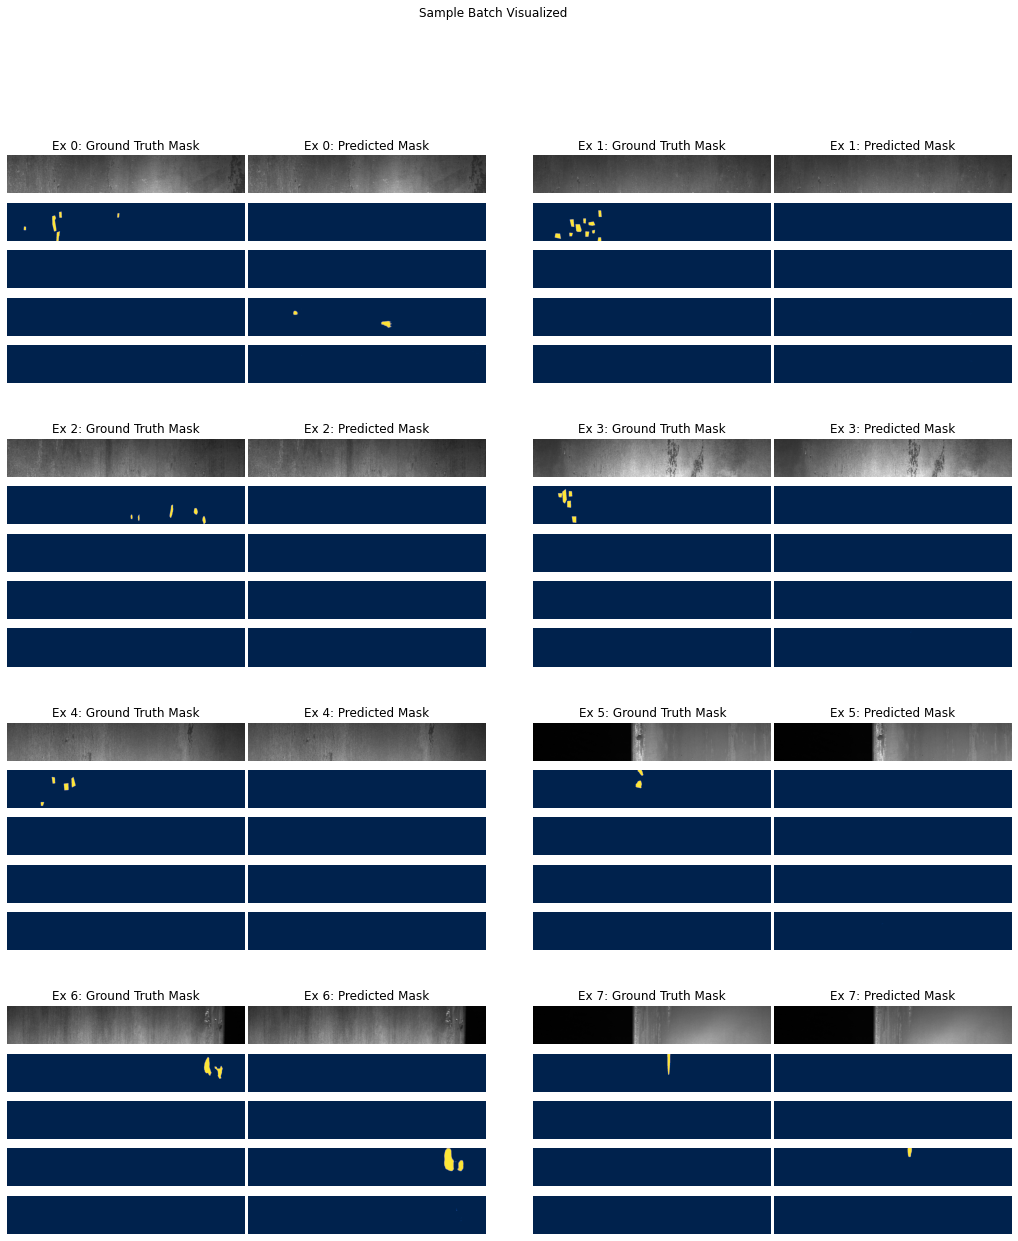

1/1 [==============================] - 0s 92ms/step


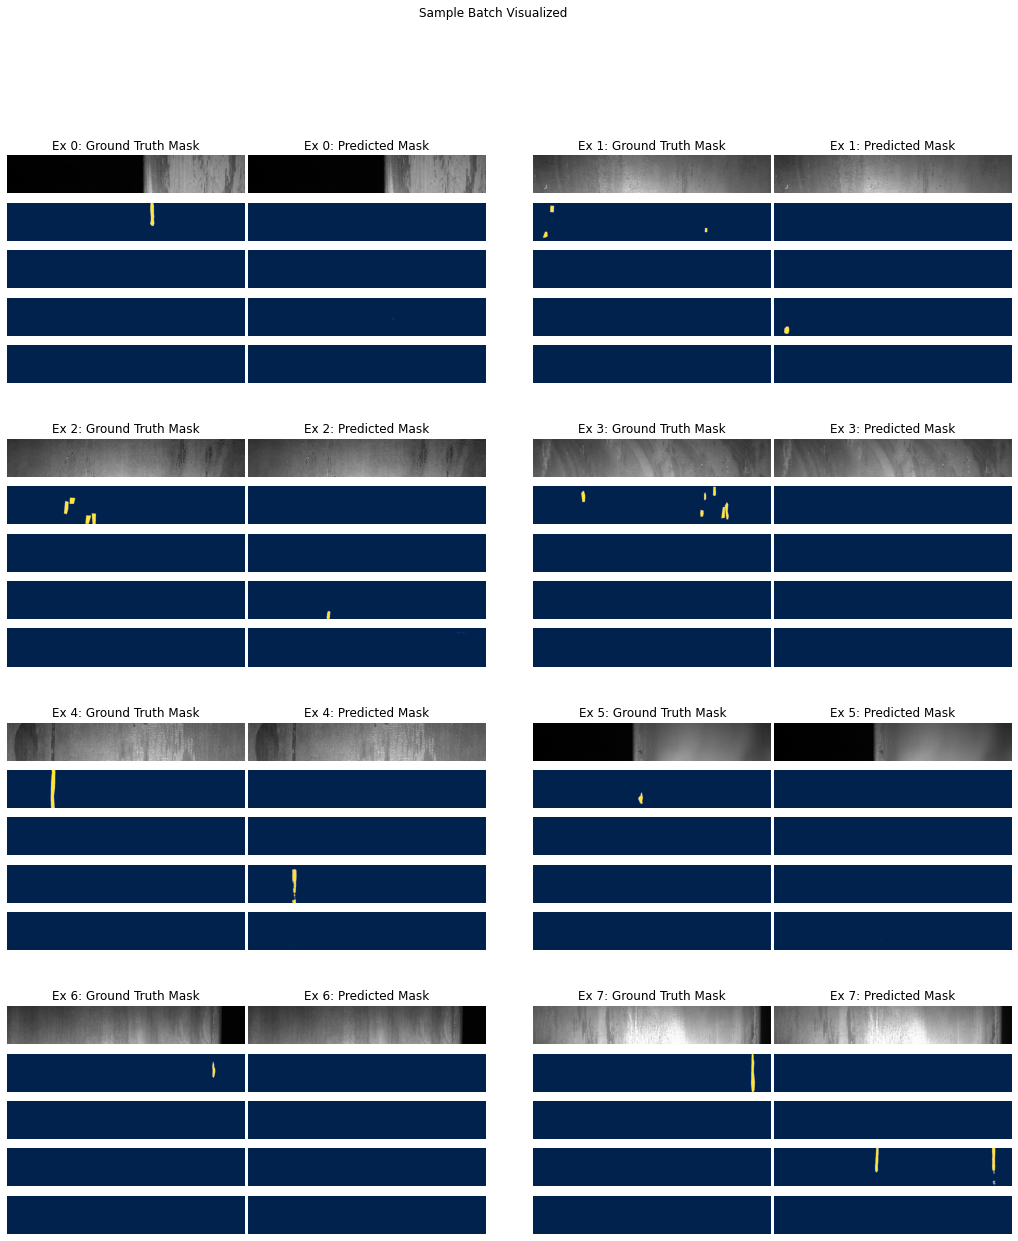

1/1 [==============================] - 0s 103ms/step


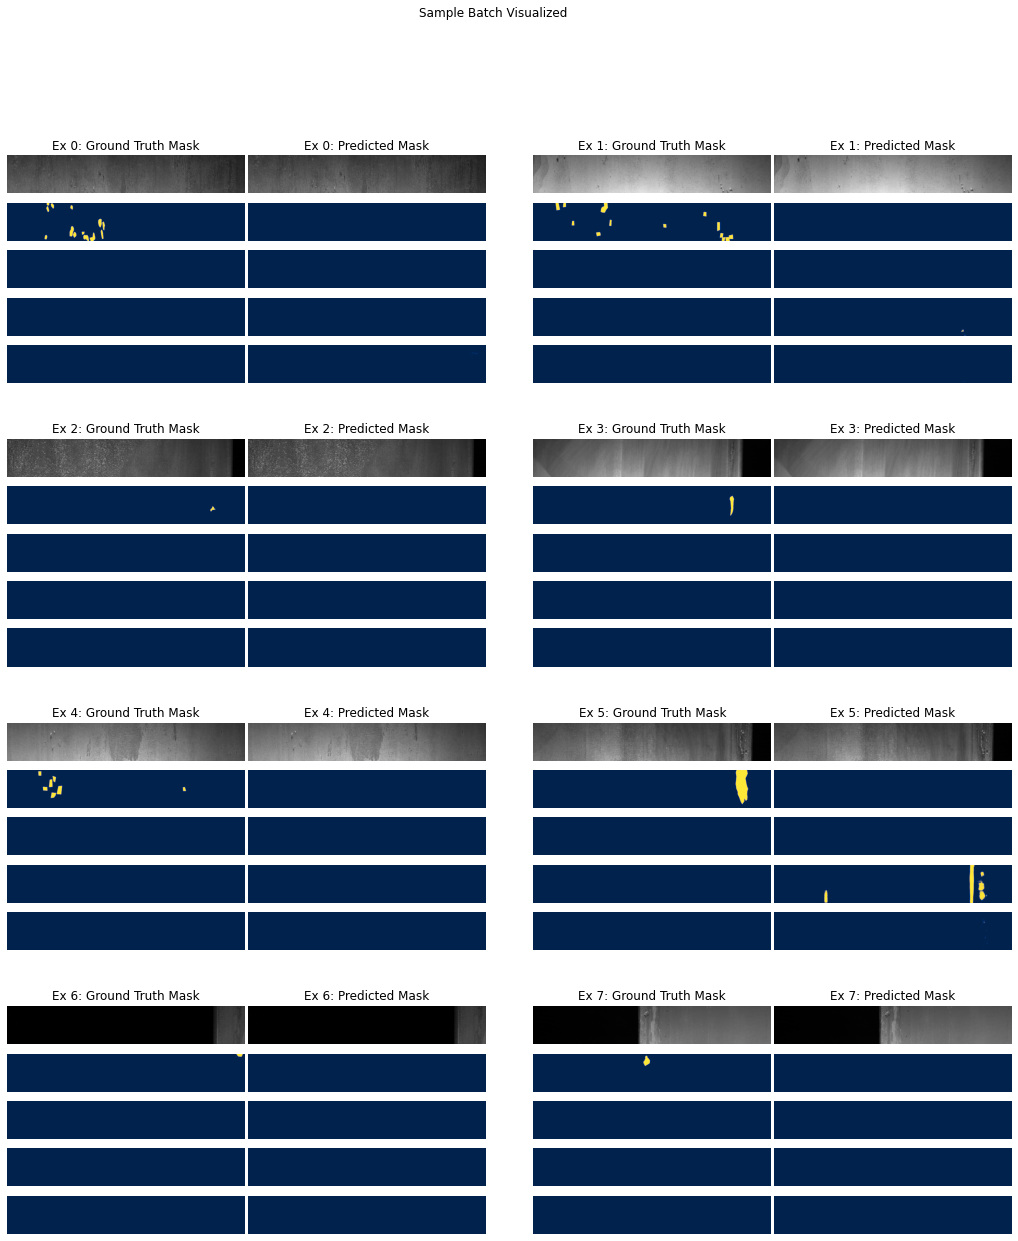

1/1 [==============================] - 0s 94ms/step


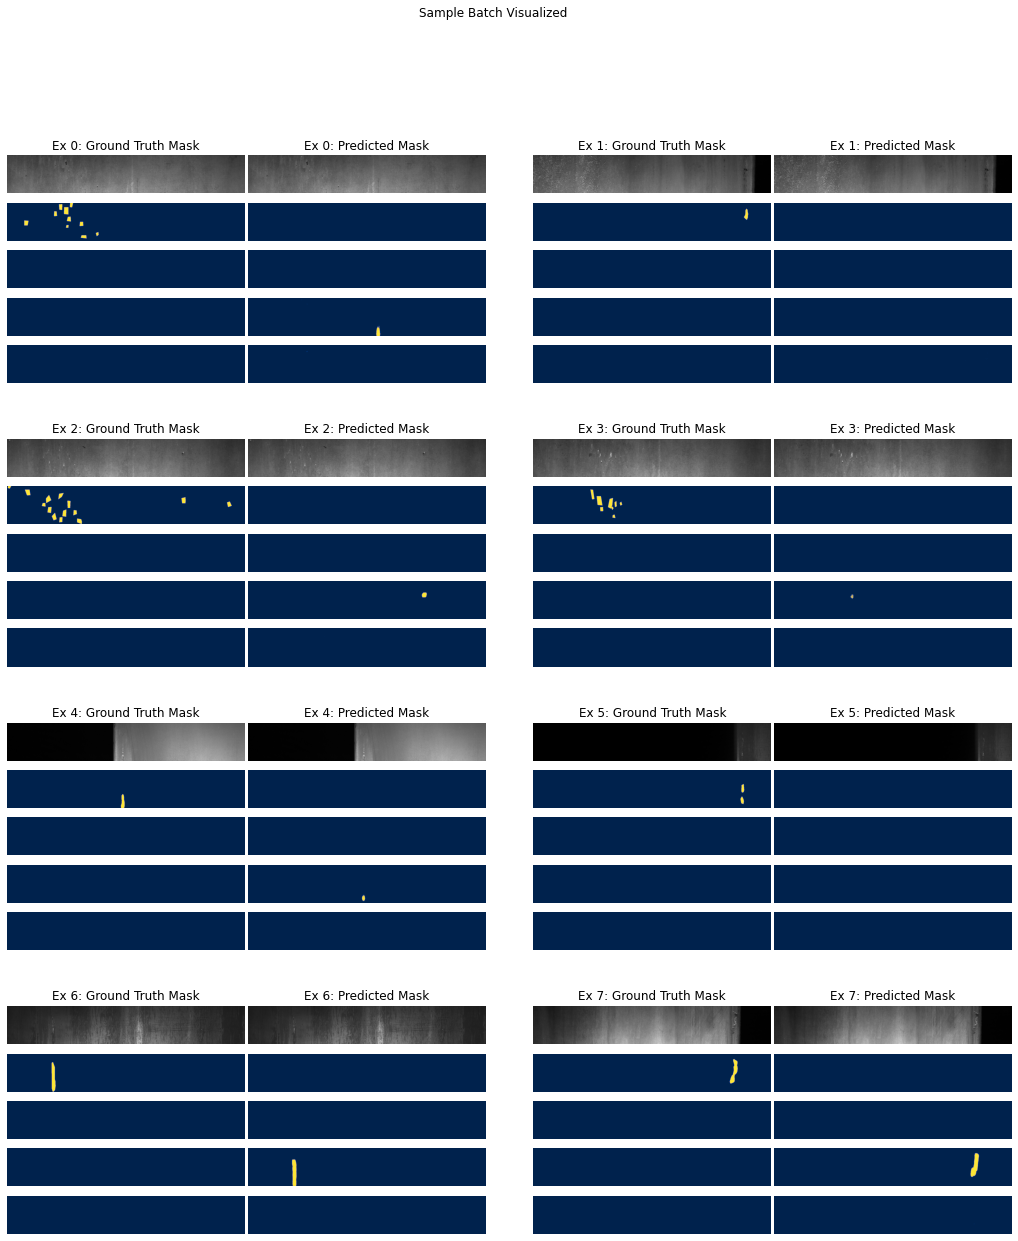

In [13]:
# class 1
plot_samples_by_class(
    class_idx=1, dataset=sd, pipeline=sdp, model=unet_model, n_batches=4
)

Batching
1/1 [==============================] - 0s 54ms/step


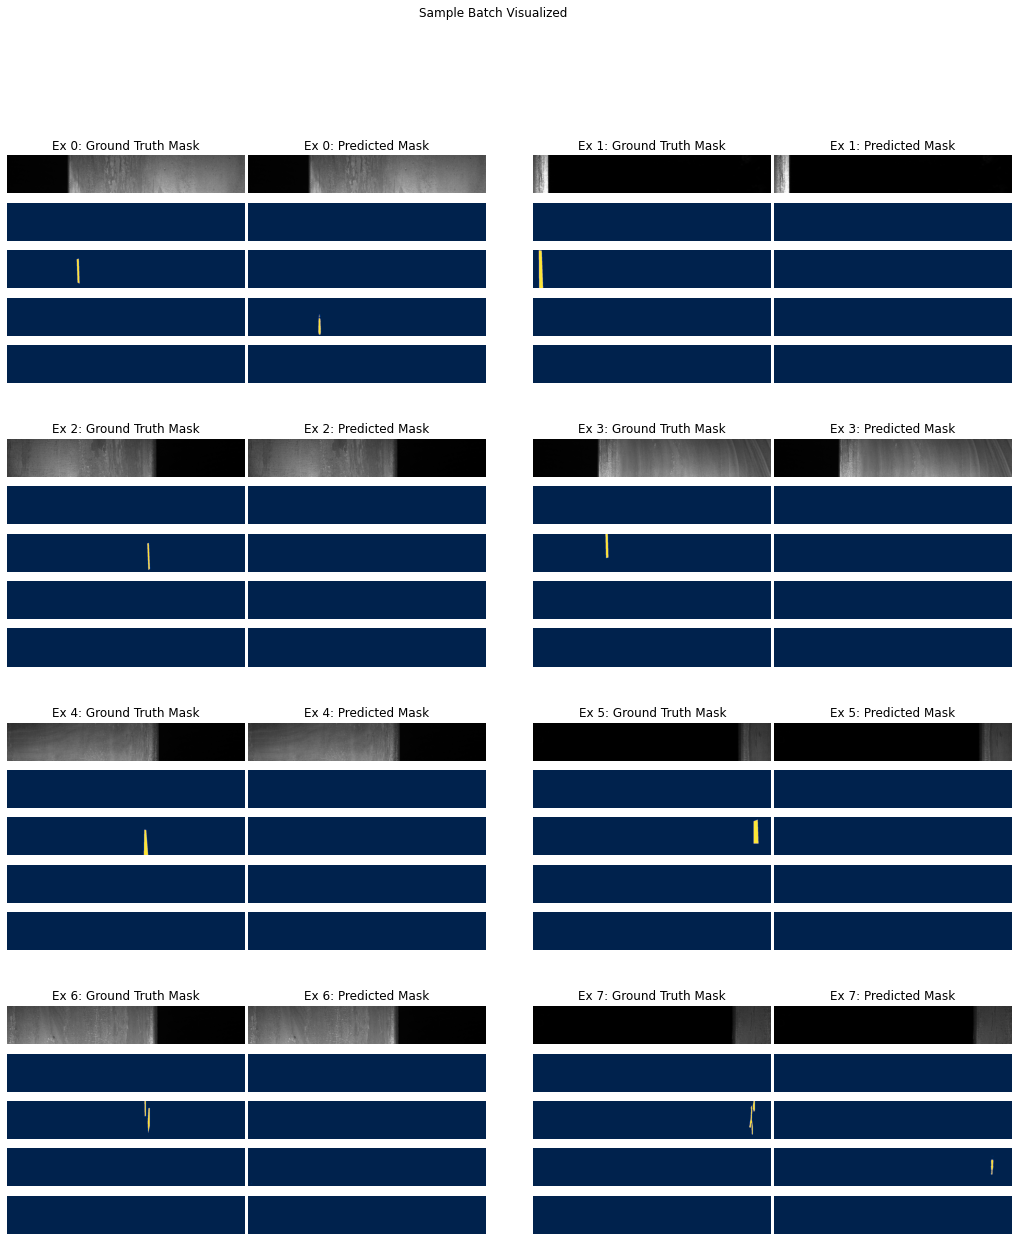

1/1 [==============================] - 0s 84ms/step


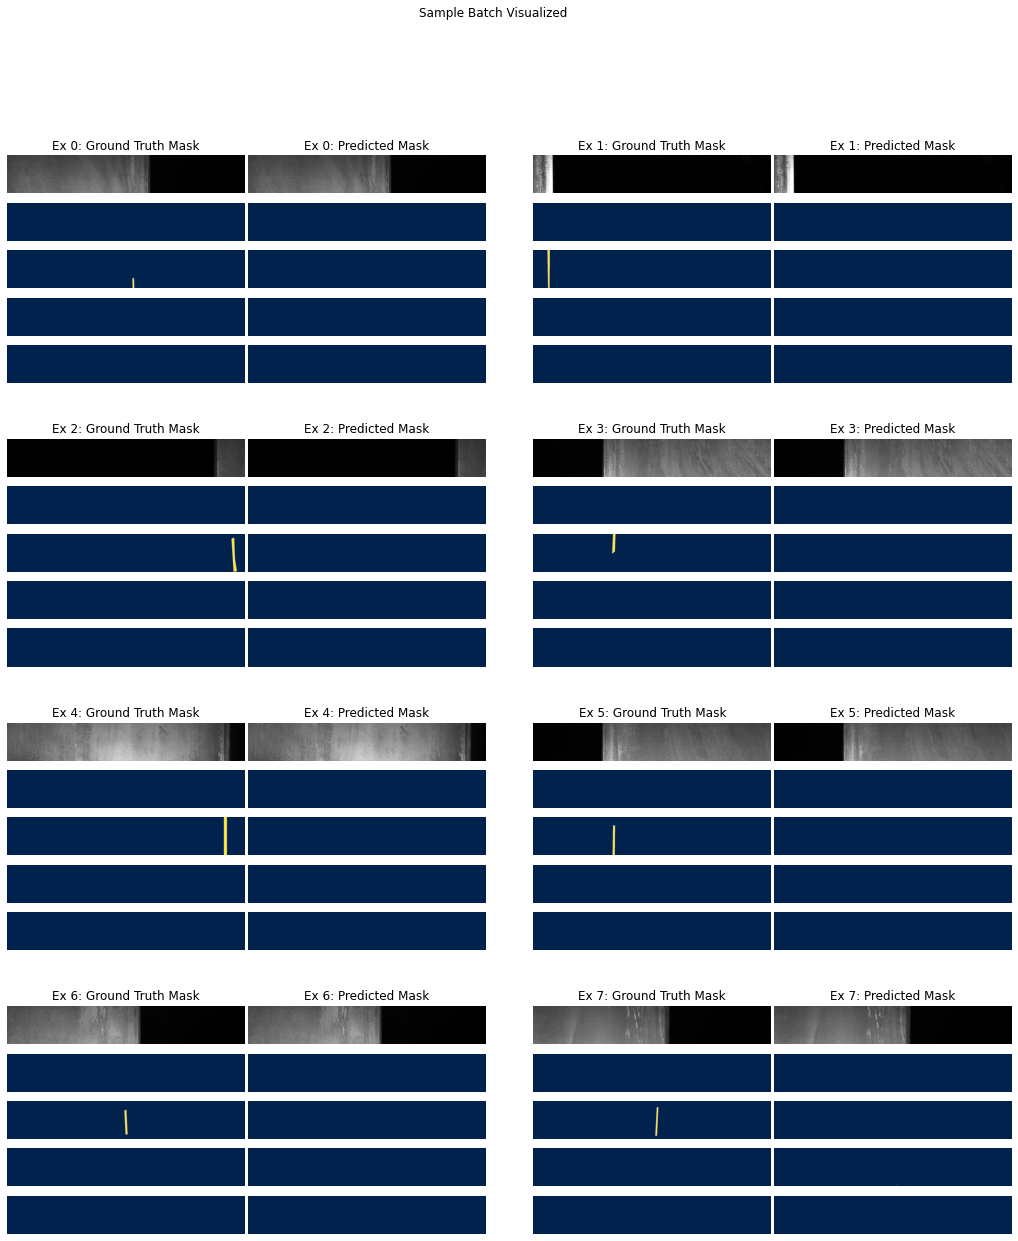

1/1 [==============================] - 0s 89ms/step


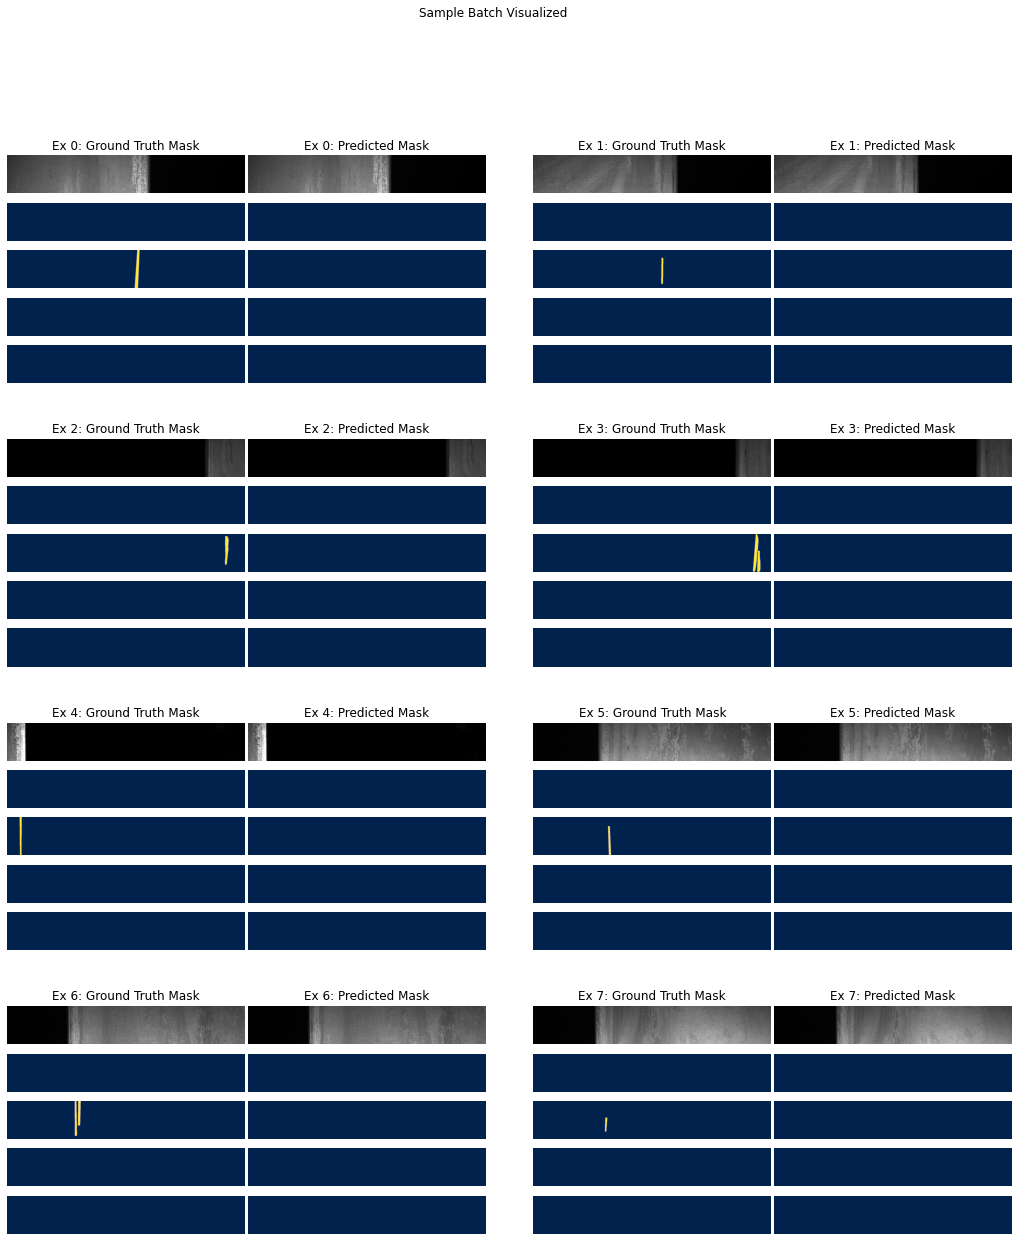

1/1 [==============================] - 0s 77ms/step


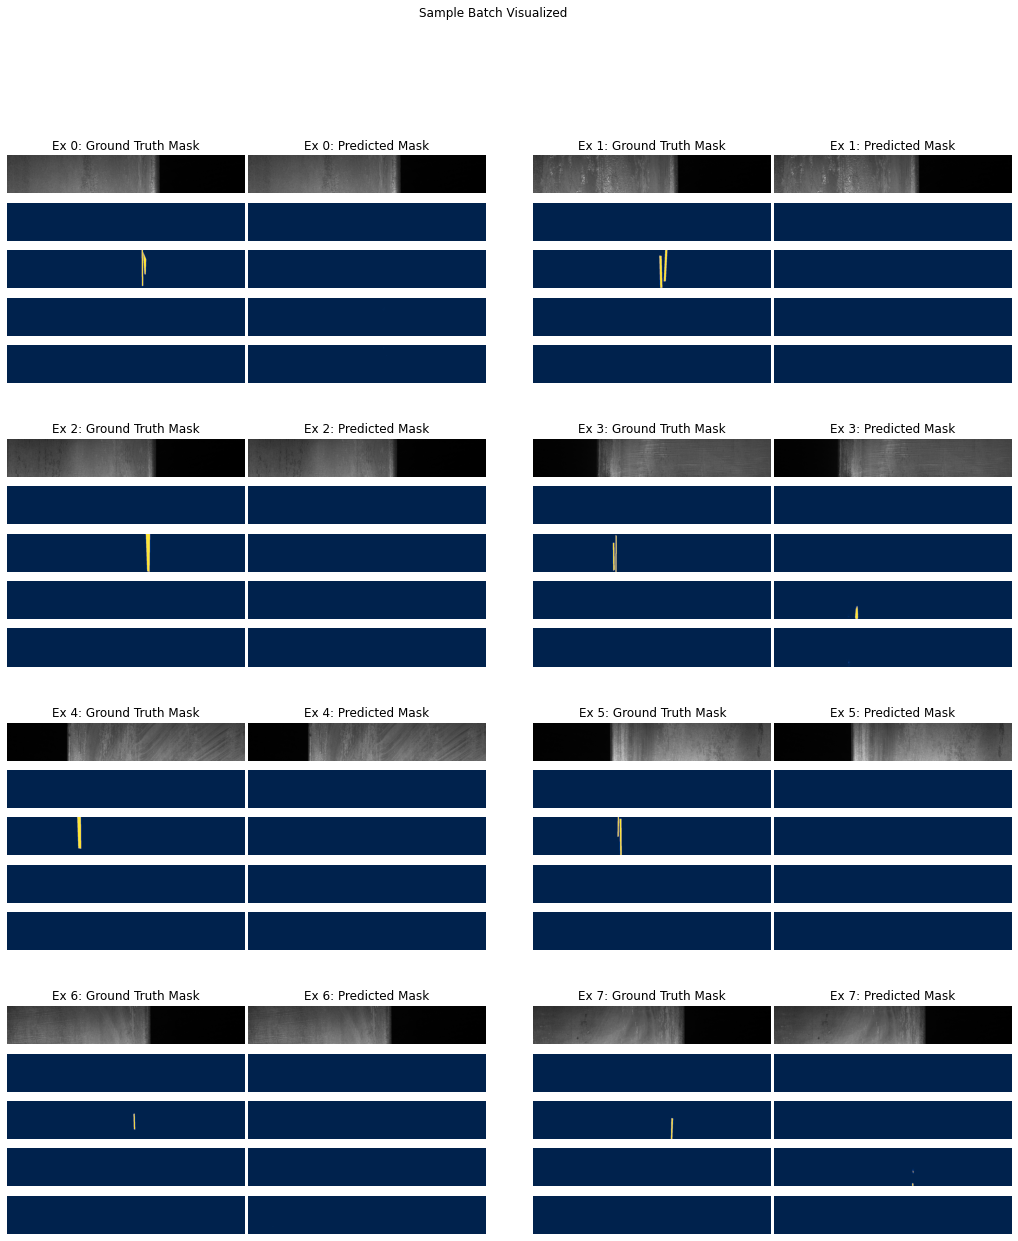

In [14]:
# class 2
plot_samples_by_class(
    class_idx=2, dataset=sd, pipeline=sdp, model=unet_model, n_batches=4
)

Batching
1/1 [==============================] - 0s 86ms/step


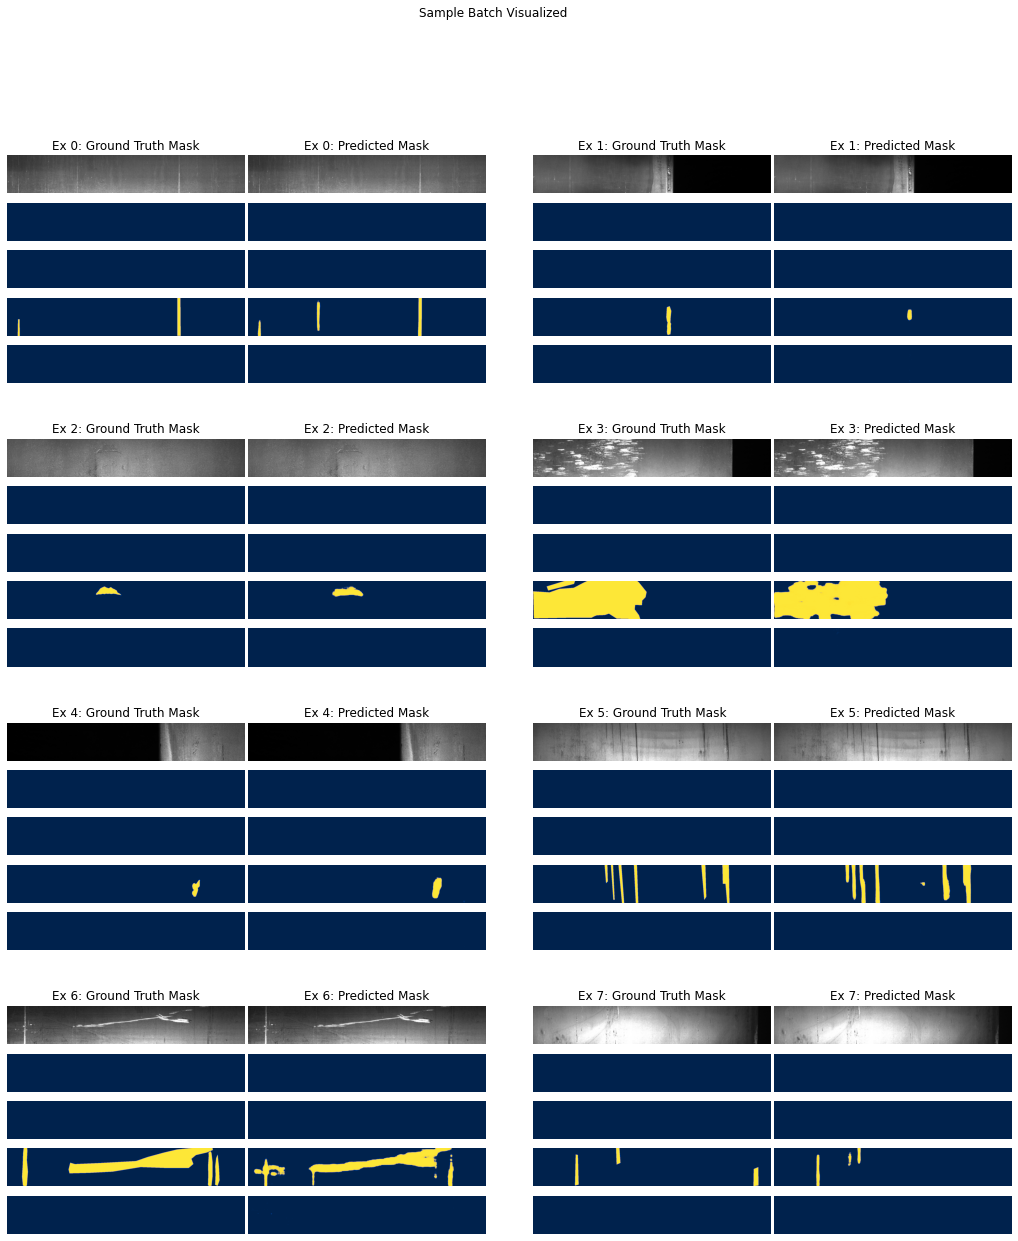

1/1 [==============================] - 0s 52ms/step


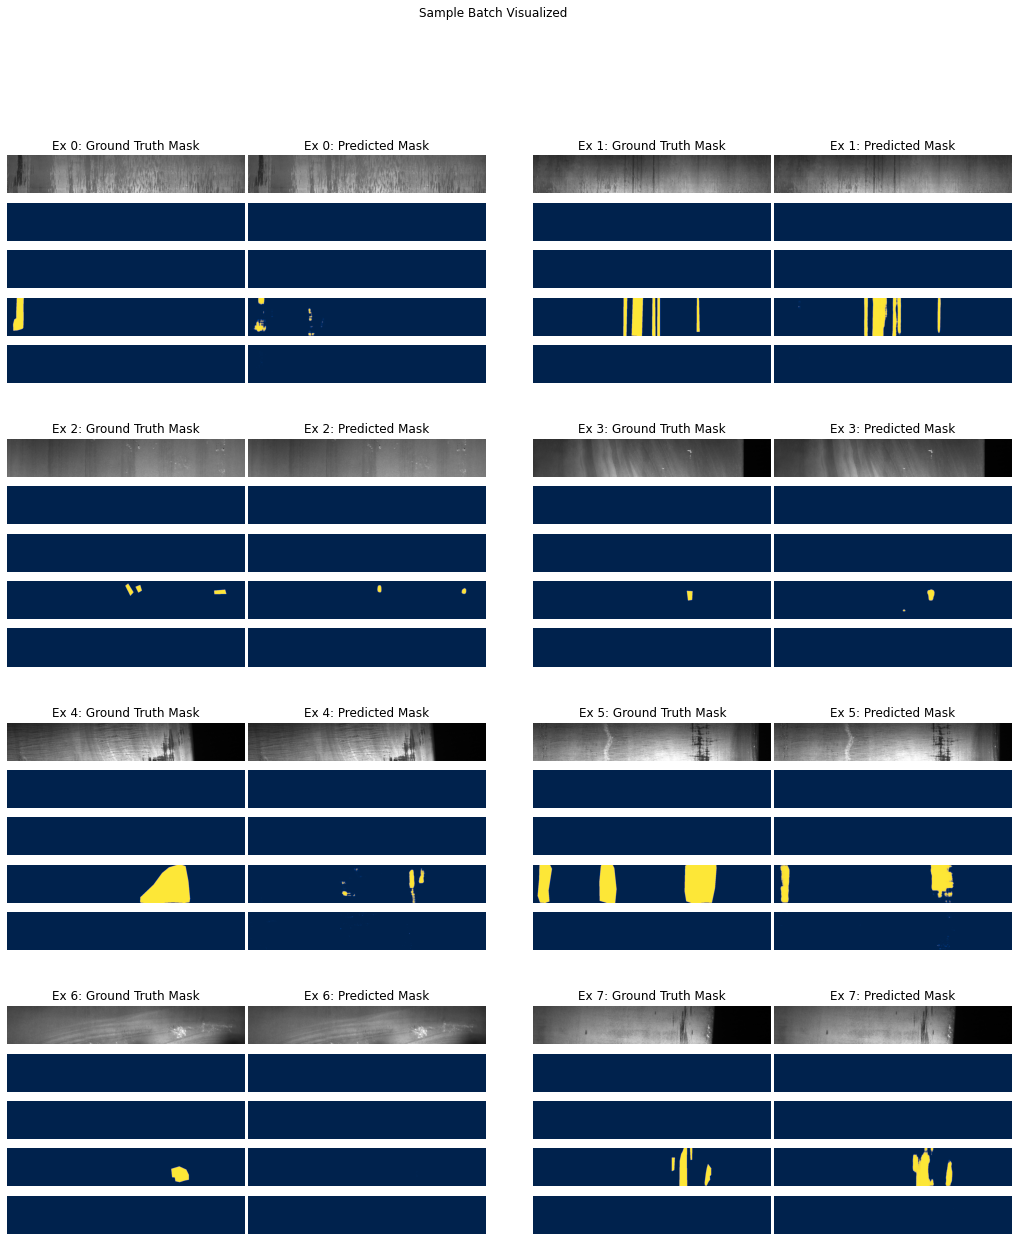

1/1 [==============================] - 0s 88ms/step


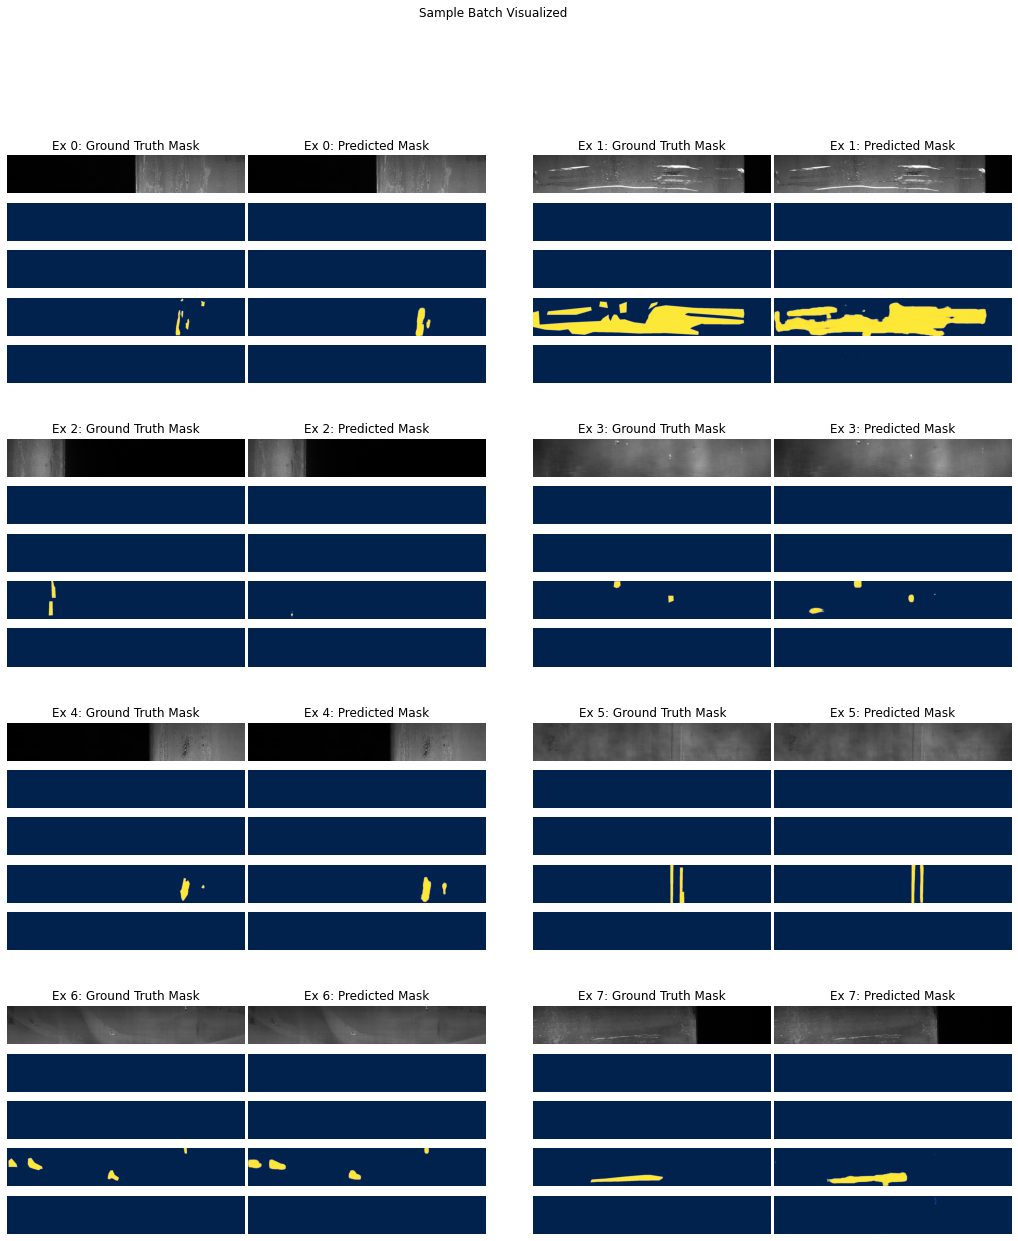

1/1 [==============================] - 0s 92ms/step


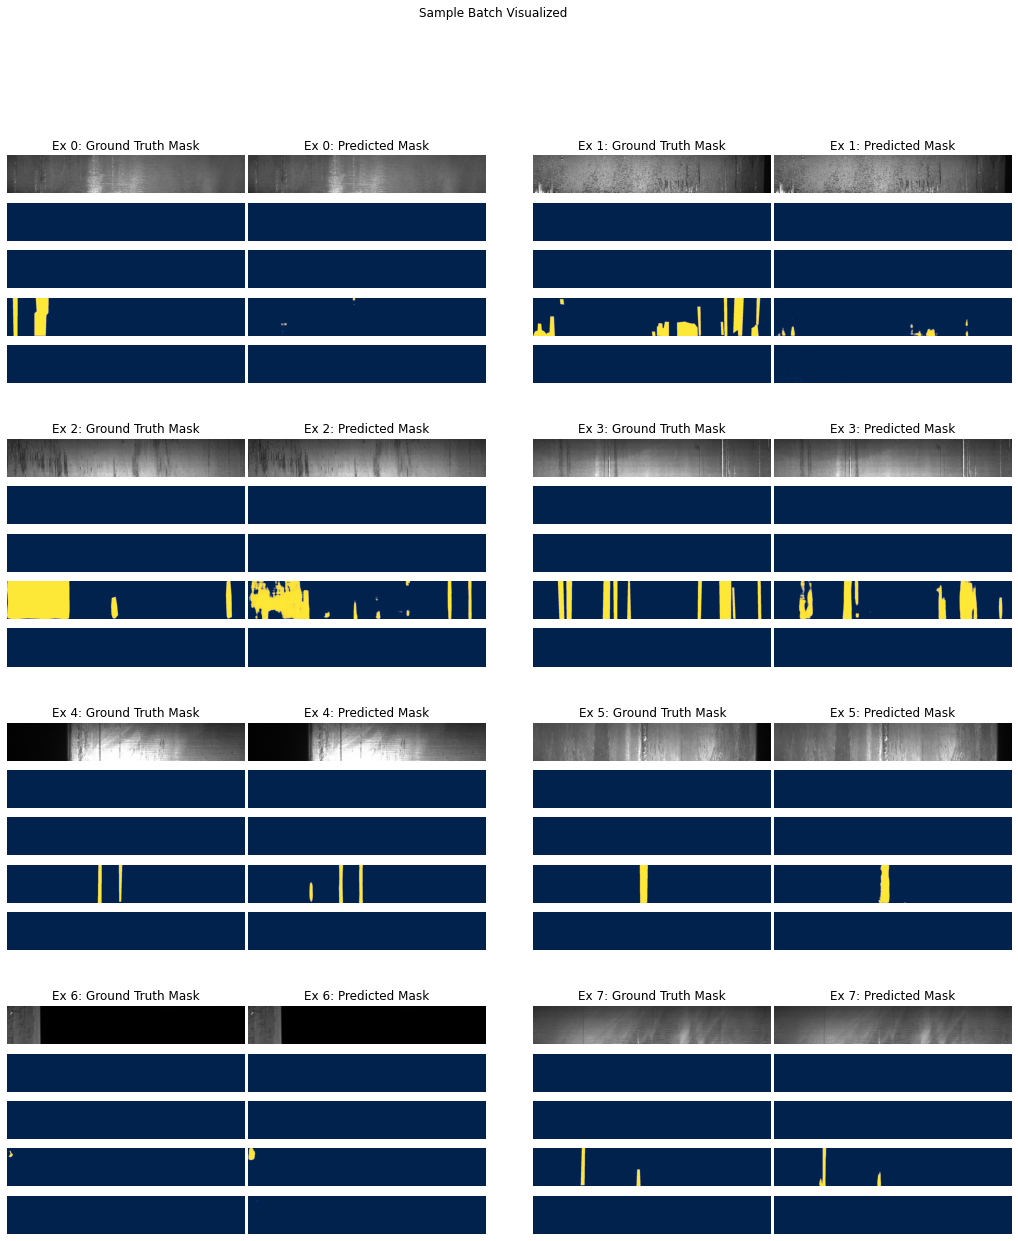

In [15]:
# class 3
plot_samples_by_class(
    class_idx=3, dataset=sd, pipeline=sdp, model=unet_model, n_batches=4
)

Batching
1/1 [==============================] - 0s 53ms/step


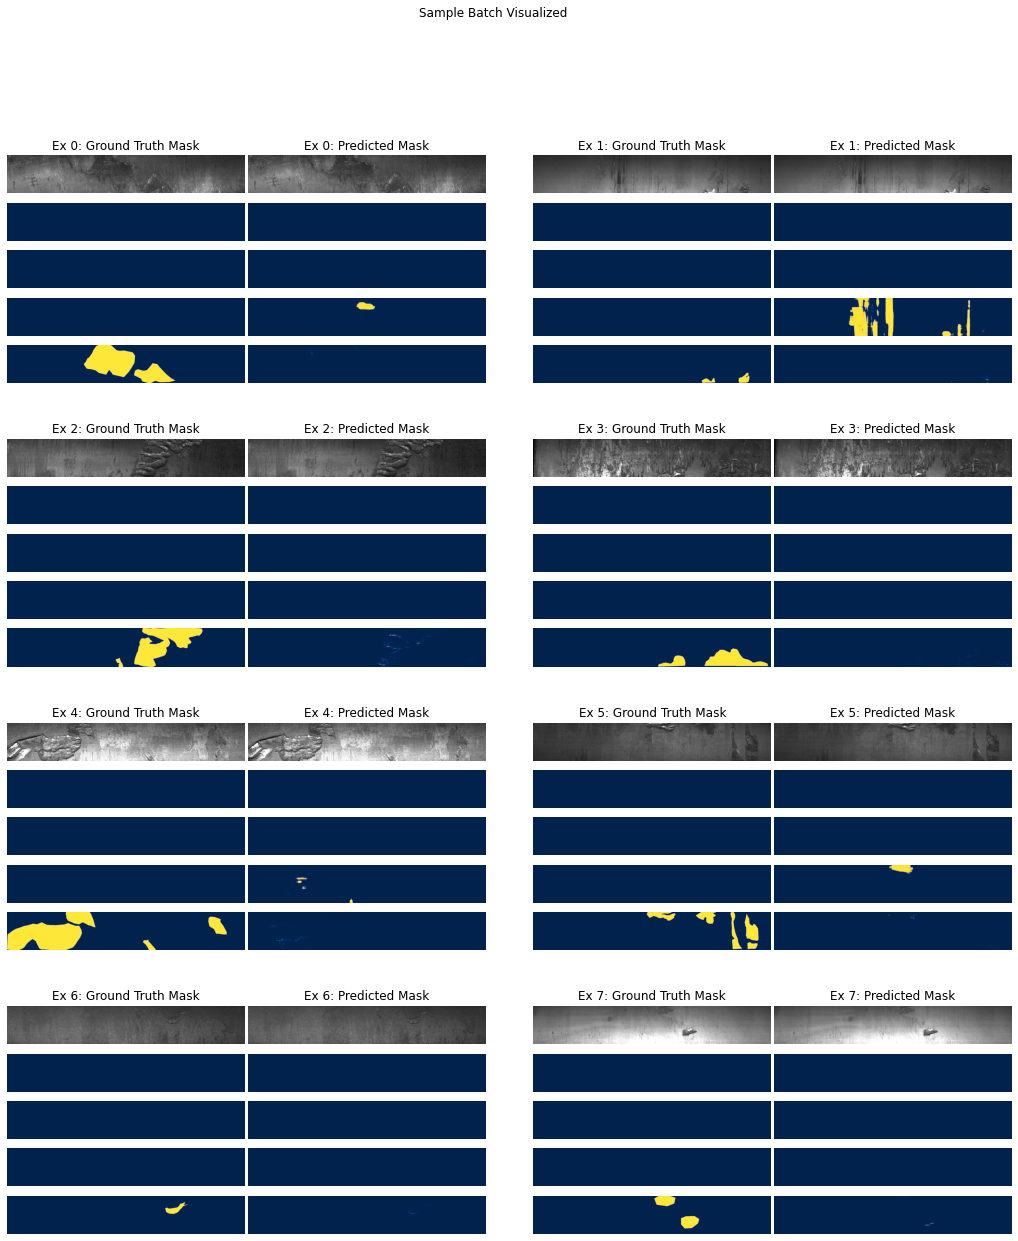

1/1 [==============================] - 0s 52ms/step


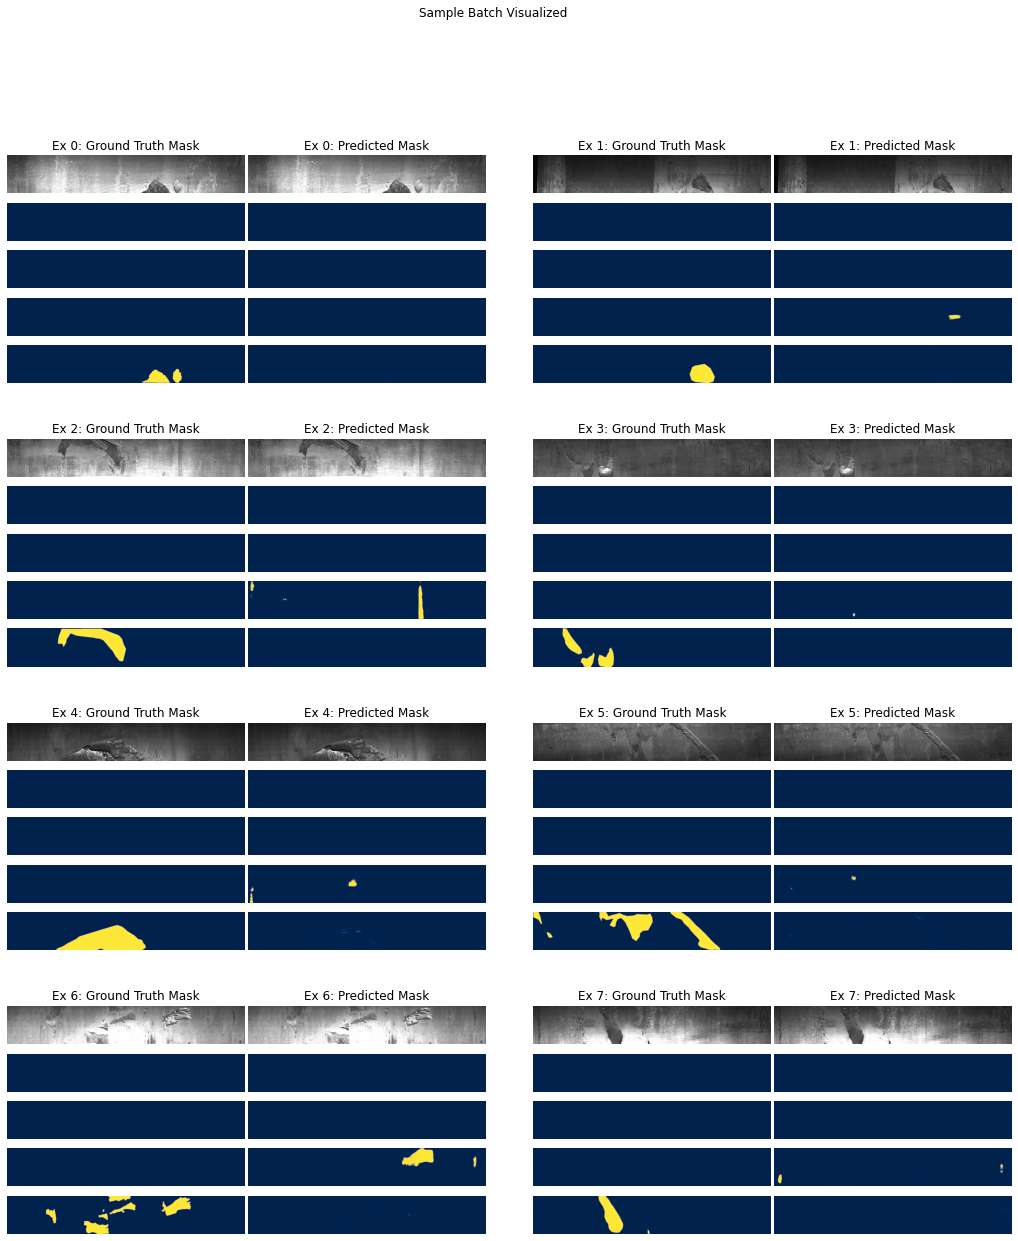

1/1 [==============================] - 0s 85ms/step


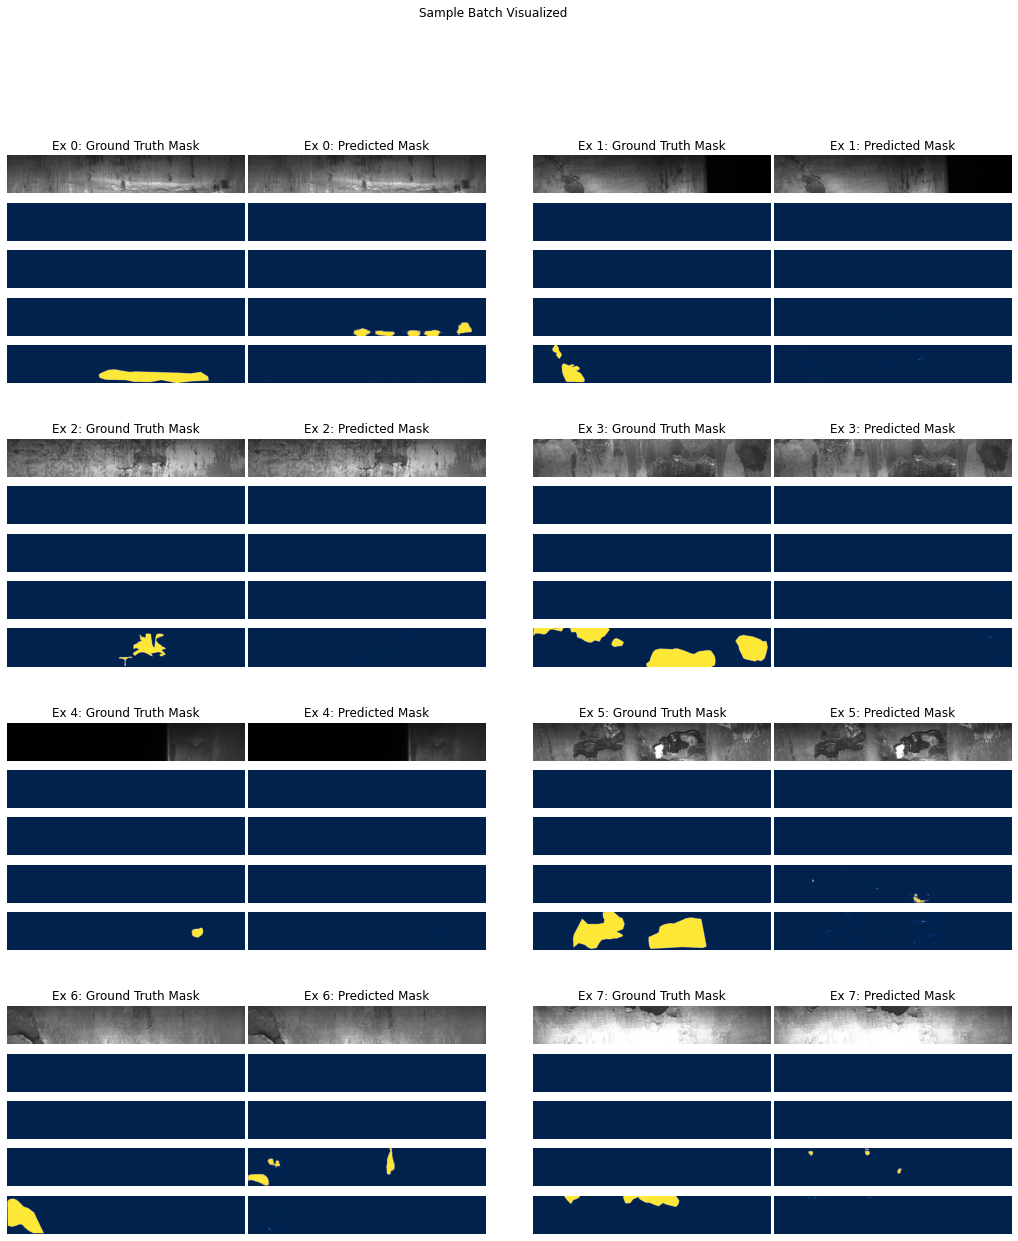

1/1 [==============================] - 0s 80ms/step


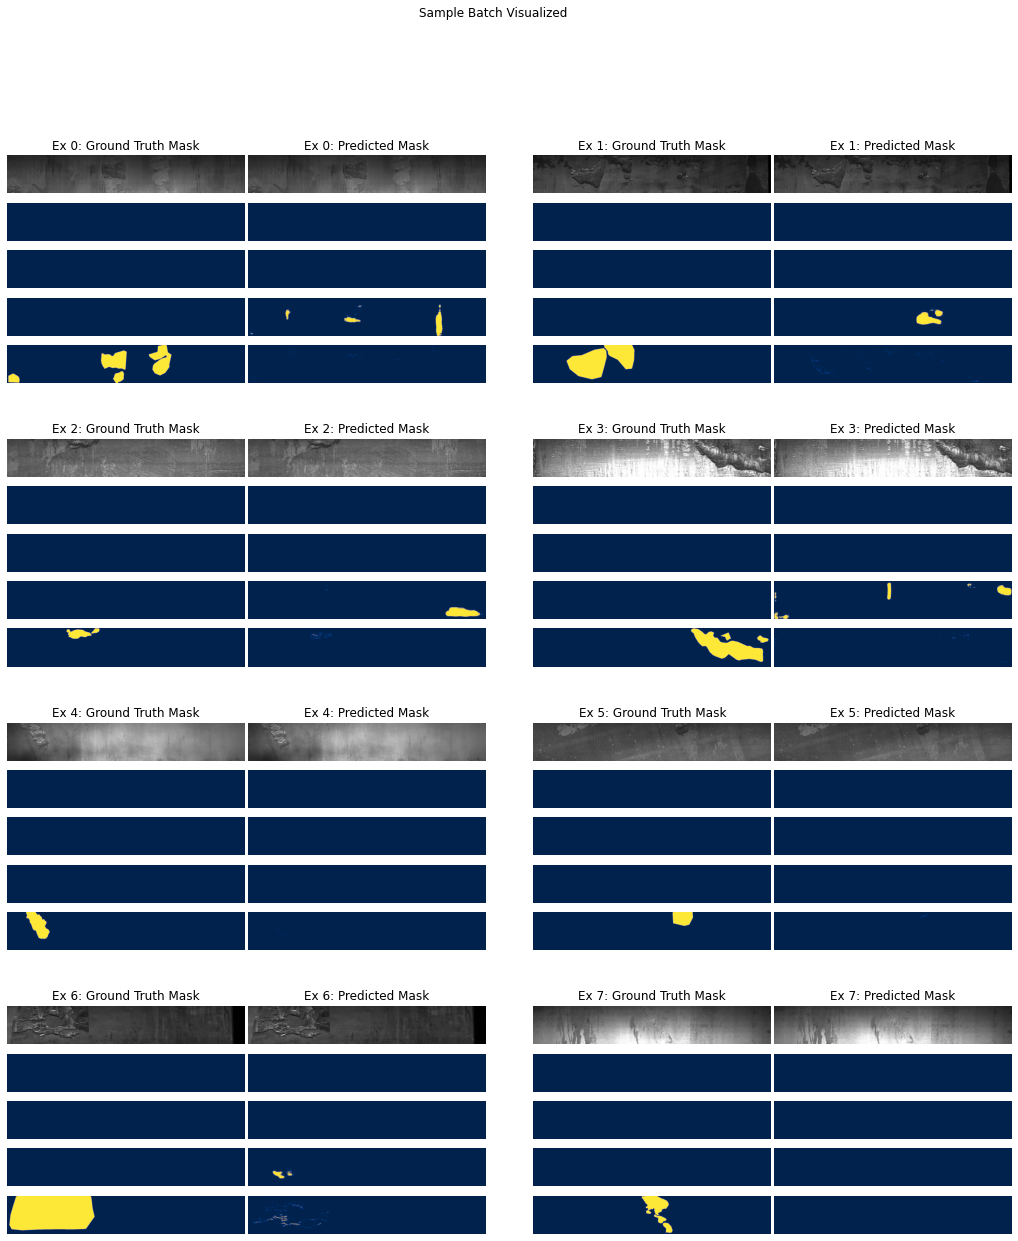

In [16]:
# class 3
plot_samples_by_class(
    class_idx=4, dataset=sd, pipeline=sdp, model=unet_model, n_batches=4
)